<a href="https://colab.research.google.com/github/subhasisj/Deep_Learning_with_PyTorch/blob/master/Demo/PyTorch_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://dev.to/kriyeng/8-tips-for-google-colab-notebooks-to-take-advantage-of-their-free-of-charge-12gb-ram-gpu-be4

https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import classification_report
import tqdm

In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Files/glass_dataset.csv')

In [3]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
df.Type.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

In [5]:
X = df.drop('Type', axis = 1)
y = df['Type']

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

sc = StandardScaler()
X = sc.fit_transform(X)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size = 0.3,stratify = y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5,stratify = y_val)

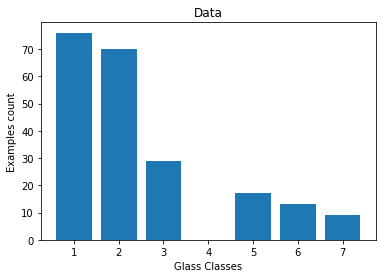

In [27]:
glass_classes = np.unique(y)
values = y.value_counts()
plt.bar(glass_classes, values)
plt.title('Data')
plt.xlabel('Glass Classes')
plt.ylabel('Examples count')
plt.show()

In [9]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

## Create Dataset class and Data Loaders

In [11]:
class Classification_Dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [12]:
train_dataset = Classification_Dataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=0)

In [13]:
test_dataset = Classification_Dataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [14]:
val_dataset = Classification_Dataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

## Define Model Architecture

In [15]:
# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class GlassClassifier(nn.Module):
    def __init__(self, num_feature, num_class):
        super(GlassClassifier, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

## Choose GPU if available.

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [17]:
!nvidia-smi

Thu Jun 25 07:12:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    33W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Move Model to GPU if available

In [18]:
model = GlassClassifier(num_feature = X.shape[1], num_class=7)
model.to(device)
print(model)

GlassClassifier(
  (layer_1): Linear(in_features=9, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [19]:
!nvidia-smi

Thu Jun 25 07:12:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    73W / 149W |    316MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Define Training and Validation Classes

In [20]:
class Training:

    def __init__(self,dataloader,model,device):
        
        self.dataloader = dataloader
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.device = device
        self.loss = nn.CrossEntropyLoss().to(device)

    def start(self):
        
        self.model.train()
        all_batch_losses = []
        
        for inputs,labels in self.dataloader:
            inputs = inputs.to(self.device)

            labels = labels.to(self.device)
            predicted_labels = self.model(inputs)
            loss_for_batch = self.loss(predicted_labels,labels)
            all_batch_losses.append(np.round(loss_for_batch.item(),4))

            # reset graph gradients
            self.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss_for_batch.backward()

            nn.utils.clip_grad_norm_(self.model.parameters(),max_norm = 1.0)

            # update network parameters
            self.optimizer.step()
       
        return np.mean(all_batch_losses)


class Validation(Training):
    def __init__(self, dataloader, model, device):
            super().__init__(dataloader, model, device)

    def start(self):
        self.model.eval()
        all_batch_losses = []

        torch.no_grad()
        for inputs,label in self.dataloader:
            inputs = inputs.to(self.device)
            label = label.to(self.device)
            predicted_label = self.model(inputs)
            loss_for_batch = self.loss(predicted_label,label)
            all_batch_losses.append(np.round(loss_for_batch.item(),4))


        return np.mean(all_batch_losses)

## Start Training

In [21]:
EPOCHS = 100

trainer = Training(train_loader,model,device)
validation = Validation(val_loader,model,device)
epoch_losses = []
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1} / {EPOCHS}:')
    try:
        training_loss_for_epoch = trainer.start()
        epoch_losses.append(training_loss_for_epoch)
        print(f'Training Loss: Epoch {epoch+1} ,Loss: {np.round(training_loss_for_epoch,4)}')
    
        validation_loss_for_epoch = validation.start()
        print(f'Validation Loss: Epoch {epoch+1} ,Loss: {np.round(validation_loss_for_epoch,4)}')
    except Exception as e:
        print(f'Exception occurred during training at epoch {epoch+1} because {str(e)}')
        break

Epoch: 1 / 100:
Training Loss: Epoch 1 ,Loss: 1.7683
Validation Loss: Epoch 1 ,Loss: 1.8499
Epoch: 2 / 100:
Training Loss: Epoch 2 ,Loss: 1.4615
Validation Loss: Epoch 2 ,Loss: 1.7623
Epoch: 3 / 100:
Training Loss: Epoch 3 ,Loss: 1.3034
Validation Loss: Epoch 3 ,Loss: 1.6573
Epoch: 4 / 100:
Training Loss: Epoch 4 ,Loss: 1.2172
Validation Loss: Epoch 4 ,Loss: 1.5436
Epoch: 5 / 100:
Training Loss: Epoch 5 ,Loss: 1.1317
Validation Loss: Epoch 5 ,Loss: 1.4326
Epoch: 6 / 100:
Training Loss: Epoch 6 ,Loss: 1.0383
Validation Loss: Epoch 6 ,Loss: 1.334
Epoch: 7 / 100:
Training Loss: Epoch 7 ,Loss: 0.9387
Validation Loss: Epoch 7 ,Loss: 1.251
Epoch: 8 / 100:
Training Loss: Epoch 8 ,Loss: 0.9507
Validation Loss: Epoch 8 ,Loss: 1.166
Epoch: 9 / 100:
Training Loss: Epoch 9 ,Loss: 0.8482
Validation Loss: Epoch 9 ,Loss: 1.1016
Epoch: 10 / 100:
Training Loss: Epoch 10 ,Loss: 0.8527
Validation Loss: Epoch 10 ,Loss: 1.05
Epoch: 11 / 100:
Training Loss: Epoch 11 ,Loss: 0.7963
Validation Loss: Epoch 11 ,

In [32]:
predictions = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        y_pred = torch.log_softmax(y_pred, dim = 1)
        _, y_pred_index = torch.max(y_pred, dim = 1)
        predictions.append(y_pred_index.cpu().numpy())

In [34]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.57      0.67      0.62        12
           2       0.00      0.00      0.00         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         1
           5       0.67      0.80      0.73         5

    accuracy                           0.67        33
   macro avg       0.67      0.62      0.63        33
weighted avg       0.67      0.67      0.66        33



In [35]:
!nvidia-smi

Thu Jun 25 07:20:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    74W / 149W |    321MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Save PyTorch Model

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [41]:
SAVE_PATH = './glass_classifier.pth'

In [42]:
torch.save(model.state_dict(), SAVE_PATH )

## Load Model

In [43]:
loaded_model = model.load_state_dict(torch.load(SAVE_PATH))

## Avoid boilerplate code with PyTorch Lightning

https://github.com/PyTorchLightning/pytorch-lightning

In [ ]:
|